This notebook analyzes the Boulder dataset from NIST linked https://nextg.nist.gov/submissions/112. The first half of the notebook is from tutorial #5 to process the data. 

In [141]:
import glob
from scipy.io import loadmat

import os
from sionna.rt import load_scene, Transmitter, Receiver, PlanarArray, PathSolver

from sklearn.metrics import mean_squared_error, mean_absolute_error,root_mean_squared_error

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import math
import random

import sys

os.chdir('/Users/davidlee/Desktop/Sionna_Boulder/geo2sigmap')
sys.path.append(os.path.abspath('./src'))
from scene_generation.core import Scene
from scene_generation.utils import rect_from_point_and_size, get_utm_epsg_code_from_gps, gps_to_utm_xy, get_center_subarray
from scene_generation.empirical_pathloss_model import pathloss_38901
from scene_generation.unet.unet_model_rt import UNet

# Mitsuba components for advanced scene operation
import mitsuba as mi
import drjit as dr

In [142]:
# LOS or NLOS for measurement type
measurement_type1 = "NLOS"
measurement_type2 = "LOS"

In [143]:
def initialize_header(measurement_type):
    # Initialize header data structure
    header_dict = {"file_name":[], "mea_idx":[]}
    header_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/Header files/".format(measurement_type)  
    header_mat_files = glob.glob(f"{header_folder_path}/*.mat")  
    print(header_mat_files[:3]) 
    return header_dict, header_folder_path, header_mat_files

In [144]:
NLOS_header_dict, NLOS_header_folder_path, NLOS_header_mat_files = initialize_header(measurement_type1)
LOS_header_dict, LOS_header_folder_path, LOS_header_mat_files = initialize_header(measurement_type2)

['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002150hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002142hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/Header files/F0002174hdr.mat']
['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001599hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001587hdr.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/Header files/F0001595hdr.mat']


In [145]:
def extract_header_info(header_dict, header_mat_files):
    # MATLAB to Python data conversion
    for mat_file_path in header_mat_files: 

        #Load the .mat file
        data = loadmat(mat_file_path)

        # Store basic file info
        header_dict["file_name"].append(os.path.basename(mat_file_path))
        header_dict["mea_idx"].append(os.path.basename(mat_file_path)[4:4+4])

        # Recursive struct parsing
        for key in data:
            if not key.startswith("__"):  # Ignore metadata keys
                value = data[key]
                if isinstance(value, np.ndarray) and value.dtype.names:
                        for name in value.dtype.names:
                            tmp_value =  data[key][0][name]
                            try:
                                tmp_value = tmp_value.item()
                                tmp_value = tmp_value.squeeze()
                                tmp_value = tmp_value.item()
                            except Exception as e:
                                pass
                            if ("{}_{}".format(key, name)) not in header_dict:
                                header_dict[("{}_{}".format(key, name))] = []
                            header_dict[("{}_{}".format(key, name))].append(tmp_value)
                else:
                    tmp_value = data[key]
                    try:
                        tmp_value = tmp_value.item()
                        tmp_value = tmp_value.squeeze()
                        tmp_value = tmp_value.item()
                    except Exception as e:
                        pass
                    if "{}".format(key) not in header_dict:
                        header_dict[("{}".format(key))] = []
                    header_dict[("{}".format(key))].append(tmp_value)

                    
    return header_dict

In [146]:
NLOS_header_dict = extract_header_info(NLOS_header_dict, NLOS_header_mat_files)
LOS_header_dict = extract_header_info(LOS_header_dict, LOS_header_mat_files)

In [147]:
NLOS_header_df = pd.DataFrame(NLOS_header_dict)
LOS_header_df = pd.DataFrame(LOS_header_dict)

In [148]:
def assert_errors(header_df):
    # Assert checks for data consistency
    assert header_df['TxData_lat_Deg'].nunique() == 1,"Error: Mupltiple TX latitudes detected"
    assert header_df['TxData_long_Deg'].nunique() == 1,"Error: Mupltiple TX longitudes detected" 
    assert header_df['TxData_alt'].nunique() == 1,"Error: Mupltiple TX altitudes detected" 

In [149]:
assert_errors(NLOS_header_df)
assert_errors(LOS_header_df)

In [150]:
def initialize_MPC(measurement_type):
    # Initialize MPC data structure
    mpc_dict = {"file_name":[], "mea_idx":[]}
    mpc_folder_path = "./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_{}/MPC files/".format(measurement_type)  
    mpc_mat_files = glob.glob(f"{mpc_folder_path}/*.mat")  
    print(mpc_mat_files[:3]) 
    return mpc_dict, mpc_folder_path, mpc_mat_files

In [151]:
NLOS_mpc_dict, NLOS_mpc_folder_path, NLOS_mpc_mat_files = initialize_MPC(measurement_type1)
LOS_mpc_dict, LOS_mpc_folder_path, LOS_mpc_mat_files = initialize_MPC(measurement_type2)

['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2266.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2267.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_NLOS/MPC files/MPC2259.mat']
['./data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1586.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1592.mat', './data/measurements/Boulder_Downtown/Measurements/BoulderDowntown_28GHz_LOS/MPC files/MPC1593.mat']


In [152]:
def format_MPC_dict(MPC_dict, MPC_mat_files):
    # MATLAB to Python data conversion
    for mat_file_path in MPC_mat_files: 

        #Load the .mat file
        data = loadmat(mat_file_path)

        # Store basic file info
        MPC_dict["file_name"].append(os.path.basename(mat_file_path))
        MPC_dict["mea_idx"].append(os.path.basename(mat_file_path)[3:3+4])

        # Recursive struct parsing
        for key in data:
            if not key.startswith("__"):  # Ignore metadata keys
                value = data[key]
                if isinstance(value, np.ndarray) and value.dtype.names:
                        for name in value.dtype.names:
                            tmp_value =  data[key][0][name]
                            try:
                                tmp_value = tmp_value.item()
                                tmp_value = tmp_value.squeeze()
                                tmp_value = tmp_value.item()
                            except Exception as e:
                                pass
                            if ("{}_{}".format(key, name)) not in MPC_dict:
                                MPC_dict[("{}_{}".format(key, name))] = []
                            MPC_dict[("{}_{}".format(key, name))].append(tmp_value)
                else:
                    tmp_value = data[key]
                    try:
                        tmp_value = tmp_value.item()
                        tmp_value = tmp_value.squeeze()
                        tmp_value = tmp_value.item()
                    except Exception as e:
                        pass
                    if "{}".format(key) not in MPC_dict:
                        MPC_dict[("{}".format(key))] = []
                    MPC_dict[("{}").format(key)].append(tmp_value)

                    
    return MPC_dict

In [153]:
NLOS_MPC_dict =  format_MPC_dict(NLOS_mpc_dict, NLOS_mpc_mat_files)
LOS_MPC_dict =  format_MPC_dict(LOS_mpc_dict, LOS_mpc_mat_files)


In [154]:
NLOS_MPC_df = pd.DataFrame(NLOS_MPC_dict)
print(NLOS_MPC_df.iloc[0].to_string())
print("\n")

LOS_MPC_df = pd.DataFrame(LOS_MPC_dict)

file_name                                                            MPC2266.mat
mea_idx                                                                     2266
header_TxGainEffective_dBi                                                     2
header_TxHPBW_Effective_deg                                                 47.3
header_dist_m                                                          61.906189
header_NumSectors                                                              8
header_B2B_Attenuation_dB                                                    -15
MPC_params_sector01            [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02            [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03            [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04            [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05            [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_sector06         

In [155]:
NLOS_merged_df = pd.merge(NLOS_MPC_df, NLOS_header_df, on='mea_idx', how='inner')  
print(NLOS_merged_df.iloc[0].to_string())
LOS_merged_df = pd.merge(LOS_MPC_df, LOS_header_df, on='mea_idx', how='inner')

file_name_x                                                           MPC2266.mat
mea_idx                                                                      2266
header_TxGainEffective_dBi                                                      2
header_TxHPBW_Effective_deg                                                  47.3
header_dist_m                                                           61.906189
header_NumSectors                                                               8
header_B2B_Attenuation_dB                                                     -15
MPC_params_sector01             [[194.60000000000002, 133.19305332, 11.0, 129....
MPC_params_sector02             [[194.60000000000002, 127.69305331999999, 12.0...
MPC_params_sector03             [[194.625, 129.19305332, 11.5, 128.64943718814...
MPC_params_sector04             [[194.65, 127.69305331999999, 7.0, 128.4958396...
MPC_params_sector05             [[194.65, 131.19305332, 4.0, 128.0129647093495...
MPC_params_secto

In [156]:
def generate_scene(merged_df):
    scene_dir = "./scenes/Boulder_Downtown"

    polygon_points_gps = rect_from_point_and_size(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"],
        "center", 
        512,
        512
    )
    min_lon, min_lat = polygon_points_gps[0]
    max_lon, max_lat = polygon_points_gps[2]
    print(
        f"Check the bbox at http://bboxfinder.com/#{min_lat:.{4}f},{min_lon:.{4}f},{max_lat:.{4}f},{max_lon:.{4}f}"
    )
    scene_instance = Scene()
    scene_instance(
        polygon_points_gps,
        scene_dir,
        None,
        osm_server_addr="https://overpass-api.de/api/interpreter",
        lidar_calibration=False,
        generate_building_map=True,
        ground_material_type="mat-itu_concrete",
        rooftop_material_type = "mat-itu_metal",
        wall_material_type = "mat-itu_brick"
        
    )

    utm_epsg = get_utm_epsg_code_from_gps(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"],
    )

    top_left_coord_x_utm, top_left_coord_y_utm,_  =  gps_to_utm_xy(min_lon, max_lat, utm_epsg)
    center_coord_x_utm, center_coord_y_utm, _ = gps_to_utm_xy(
        merged_df.iloc[0]["TxData_long_Deg"],
        merged_df.iloc[0]["TxData_lat_Deg"], 
        utm_epsg
    )

    scene = load_scene("{}/scene.xml".format(scene_dir))

    # Apply transformation and store in new columns
    merged_df["GPSData_longitude_UTM"], merged_df["GPSData_latitude_UTM"], _ = zip(
        *merged_df.apply(lambda row: gps_to_utm_xy(row["GPSData_longitude_Deg"], row["GPSData_latitude_Deg"], utm_epsg), axis=1)
    )

    merged_df["Sionna_Rx_x"], merged_df["Sionna_Rx_y"] = zip(
        *merged_df.apply(lambda row: (row["GPSData_longitude_UTM"] - center_coord_x_utm, row["GPSData_latitude_UTM"] - center_coord_y_utm ), axis=1)
    )

    # Obtain the Mitsuba scene object from Sionna scene object 
    mi_scene = scene.mi_scene

    # Calculate scene bounding box excluding the ground plane
    bbox = mi.ScalarBoundingBox3f()
    for shape in mi_scene.shapes():
        if "ground" not in shape.id():
            bbox.expand(shape.bbox())

    # Generate candidate positions (with a typical UE height of 1.5m)
    # num_candidates = 1000
    candidates = np.column_stack([
        merged_df["Sionna_Rx_x"].to_numpy(),
        merged_df["Sionna_Rx_y"].to_numpy(),
        merged_df["RxData_Rxh_m"].to_numpy()
    ])

    # Create a direction vector pointing upwards (towards the sky) 
    #  and tile it to match the number of positions
    directions_np = np.tile(np.array([0, 0, 1]), (len(merged_df), 1))

    # Ray tracing validation
    rays = mi.Ray3f(
        # mi.Vector3f(candidates),
        mi.Vector3f(np.array(candidates, dtype=np.float32).T),
        mi.Vector3f(np.array(directions_np, dtype=np.float32).T)
    )
    si = mi_scene.ray_intersect(rays)
    valid_mask = ~si.is_valid()

    merged_df["is_outdoor"] = valid_mask

    # Filter and visualize
    valid_positions = candidates[valid_mask]
    invalid_positions = candidates[~valid_mask]
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(valid_positions[:,0], valid_positions[:,1], valid_positions[:,2],c="blue",label="Valid")
    ax.scatter(invalid_positions[:,0], invalid_positions[:,1], invalid_positions[:,2], c="red", label="Invalid" )
    # Add legend
    ax.legend()
    ax.set_title(f"{len(valid_positions)} Valid Outdoor Positions out of  {len(merged_df)} Points")
    plt.show()

    # Transmitter array (single isotropic element)
    scene.tx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="iso",        # isotropic pattern
        polarization="V"      # vertical polarization
    )

    # Receive array (single dipole element)
    scene.rx_array = PlanarArray(
        num_rows=1,
        num_cols=1,
        vertical_spacing=0.5,
        horizontal_spacing=0.5,
        pattern="dipole",
        polarization="V"
    )

    # Transmitter configuration
    tx = Transmitter(
        name="tx",
        position=[0, 0, float(merged_df.iloc[0]["TxData_Txh_m"])],  # Elevated position
        orientation=[0, 0, 0]  
    )
    scene.add(tx)

    # Select 10 receivers form valid_positions (Outdoor positions)
    # // for i, pos in enumerate(valid_positions[np.random.choice(valid_positions.shape[0], size=5, replace=False)]):
    for index, row in merged_df.iterrows():
        if merged_df.iloc[index]['is_outdoor'] == True:
            rx = Receiver(
                    name=f"rx_{row['mea_idx']}",
                    position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
                    orientation=[0, 0, 0] 
                )
        # if index <= 10:
        #     rx = Receiver(
        #         name=f"rx_{row['mea_idx']}",
        #         position=(row["Sionna_Rx_x"], row["Sionna_Rx_y"] , row["RxData_Rxh_m"]),
        #         orientation=[0, 0, 0] 
        #     )
            scene.add(rx)

    return scene, valid_positions

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 490.39it/s]


2025-09-09 10:01:54 WARN wrk3 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

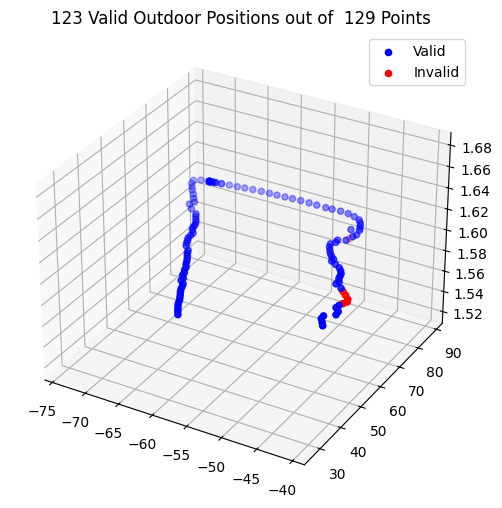

Check the bbox at http://bboxfinder.com/#40.0148,-105.2823,40.0194,-105.2763


Parsing buildings: 100%|██████████| 152/152 [00:00<00:00, 425.99it/s]


2025-09-09 10:01:55 WARN wrk4 [HDRFilm] Monochrome mode enabled, setting film output pixel format to 'luminance' (was rgb).

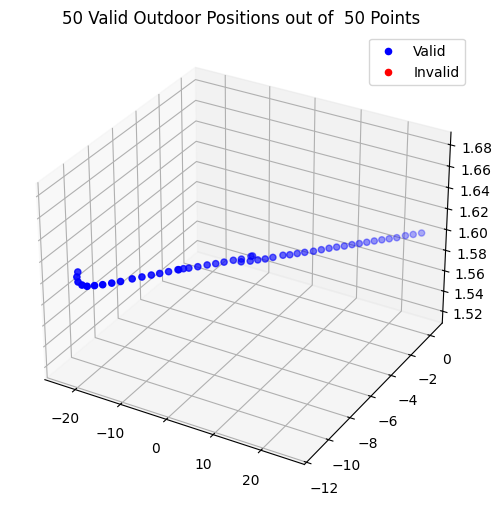

In [157]:
NLOS_scene, NLOS_valid_positions = generate_scene(NLOS_merged_df)
LOS_scene, LOS_valid_positions = generate_scene(LOS_merged_df)

In [158]:
def radio_scene(scene):
    # Configure simulation parameters
    scene.frequency = 28.5e9  
    scene.synthetic_array = True  # Optimize for array calculations

    for radio_material in scene.radio_materials.values():
        radio_material.scattering_coefficient  = 0.4

    # Perform ray tracing using PathSolver()
    solver = PathSolver()
    paths = solver(scene, 
                max_depth=2,
                los=True,
                specular_reflection=True,
                diffuse_reflection=True, 
                refraction=False,
                samples_per_src=int(1e3)
    )
    return paths


In [159]:
NLOS_paths = radio_scene(NLOS_scene)
LOS_paths = radio_scene(LOS_scene)

In [160]:
# Parse paths into a structured dataset containing detailed rays information
def create_ray_dataset(paths, merged_df, valid_positions, frequency):
    """Process raw ray data into pandas DataFrame"""
    dataset = {
        'freq': [],
        'rx_id': [],
        'type': [],
        'phi_r': [],
        'phi_t': [],
        'theta_r': [],
        'theta_t': [],
        'a':[],
        'tau':[],
        'rx_coord':[]
    }

    # See sionna.rt.constants.InteractionType
    ray_type_map = {0: "LOS", 1: "SPECULAR", 2: "DIFFUSE", 4: "REFRACTION"}
    
    a = np.asarray(paths.a).squeeze()
    tau = np.asarray(paths.tau).squeeze()
    types = np.asarray(paths.interactions).squeeze()
    mask = np.asarray(paths.valid).squeeze()
    phi_r = np.asarray(paths.phi_r).squeeze()
    phi_t = np.asarray(paths.phi_t).squeeze()
    theta_r = np.asarray(paths.theta_r).squeeze()
    theta_t = np.asarray(paths.theta_t).squeeze()
    targets = np.asarray(paths.targets).squeeze().T
    
    # Extract relevant parameters
    for idx, item in enumerate(mask):
        # Filter out the RX if it has no valid paths
        if np.sum(item==True):
            for sub_idx, sub_item in enumerate(item):
                if sub_item:
                    cur_ray_type = 0
                    num_depths = types.shape[0]
                    for depth_idx in range(num_depths-1, -1, -1):
                        cur_ray_type = types[depth_idx,idx,sub_idx]
                        # print(f"types[{depth_idx},{idx},{sub_idx}]",cur_ray_type)
                        if cur_ray_type != 0:
                            break

                    # Store the list instead of np.array to avoid the space seperator in .csv
                    dataset["freq"].append(frequency)
                    dataset["type"].append(ray_type_map[cur_ray_type])
                    z = np.complex64(a[0,idx,sub_idx] + 1j*a[1, idx,sub_idx]) 
                    dataset["a"].append(z)
                    dataset["tau"].append(tau[idx,sub_idx])

                    # Paths object only store the RX position instead of the name/idx of the RX in the Scenes Object
                    # We need to obtain the RX name by calculating the nearest RX pos due to the precision issue
                    nearest_row = merged_df.loc[
                        merged_df.apply(lambda row: (row['Sionna_Rx_x'] - targets[idx, 0])**2 + (row['Sionna_Rx_y'] - targets[idx, 1])**2, axis=1).idxmin()
                    ]
                    dataset["rx_id"].append(nearest_row["mea_idx"])
                
                    
                    dataset["rx_coord"].append(valid_positions[idx].tolist())
                    dataset["phi_r"].append(phi_r[idx,sub_idx ])                    
                    dataset["phi_t"].append(phi_t[idx,sub_idx])
                    dataset["theta_r"].append(theta_r[idx,sub_idx])
                    dataset["theta_t"].append(theta_t[idx,sub_idx])
    
    return pd.DataFrame(dataset)



In [161]:
# Generate analysis dataframe
NLOS_df = create_ray_dataset(NLOS_paths, NLOS_merged_df, NLOS_valid_positions, frequency=28.5e9)

In [162]:
LOS_df = create_ray_dataset(LOS_paths, LOS_merged_df, LOS_valid_positions, frequency=28.5e9)

In [163]:
def linear(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 ** (pg_arr_copy / 10)

def convert_to_db(pg_arr):
    pg_arr_copy = pg_arr.copy()
    return 10 * np.log10(pg_arr_copy)

def normalize(path_gain_arr):
    linear_pg = linear(path_gain_arr)
    max_val = np.max(linear_pg)
    linear_pg_norm = linear_pg / max_val
    return convert_to_db(linear_pg_norm)

In [164]:
# comparison_df collects data from the strongest path ray from Sionna to compare with the strongest path ray from the Boulder data
def find_strongest_path(merged_df, df):
    comparison_df = pd.DataFrame()
    no_signal = []

    for idx, rx_id in enumerate(merged_df['mea_idx']):
        # Get real results
        merged_df_row = merged_df[merged_df['mea_idx'] == rx_id]
        if merged_df_row['is_outdoor'].iloc[0] == True:
            tmp_tau = merged_df_row["MPC_params_sector01"].values[0][:, 0]
            tmp_aoa_az = merged_df_row["MPC_params_sector01"].values[0][:, 1]
            tmp_aoa_el = merged_df_row["MPC_params_sector01"].values[0][:, 2]
            tmp_path_gain = -1.0*merged_df_row["MPC_params_sector01"].values[0][:, 3]

            strongest_pg_idx = np.argmax(tmp_path_gain)

            # Get Sionna results
            tmp_df = df[df["rx_id"] == rx_id]
            tmp_tau_sionna = (tmp_df["tau"].values * 1e9)  # Convert to nsec
            tmp_aoa_az_sionna = (90 - (tmp_df["phi_r"].values * 180 / np.pi)) % 360
            tmp_aoa_el_sionna = (90 - (tmp_df["theta_r"].values * 180 / np.pi)) % 360

            eps = 1e-12  # small constant to avoid log(0)
            tmp_path_gain_sionna = 10 * np.log10(np.abs(tmp_df["a"].values)**2 + eps)
            tmp_ray_type_sionna = tmp_df["type"]
            
            # Apply threshold
            threshold_value = -140
            mask = tmp_path_gain_sionna >= threshold_value

            # Apply mask to all arrays
            tmp_tau_sionna = tmp_tau_sionna[mask]
            tmp_aoa_az_sionna = tmp_aoa_az_sionna[mask]
            tmp_aoa_el_sionna = tmp_aoa_el_sionna[mask]
            tmp_path_gain_sionna = tmp_path_gain_sionna[mask]

            tmp_pg_norm = normalize(tmp_path_gain)

            if len(tmp_path_gain_sionna) > 0:
                threshold_pg_sionna_norm = normalize(np.array(list(tmp_path_gain_sionna)))

                # Add Strongest Rays
                strongest_sionna_pg_idx = np.argmax(tmp_path_gain_sionna)
                new_row_df = pd.DataFrame([{'rx_id':rx_id, 
                                        'Strongest PG (dB)': tmp_path_gain[strongest_pg_idx], 
                                        'AoA El': tmp_aoa_el[strongest_pg_idx] % 360,
                                        'AoA Az': tmp_aoa_az[strongest_pg_idx] % 360,
                                        'Delay (ns)': tmp_tau[strongest_pg_idx],
                                        'Strongest Sionna PG (dB)': tmp_path_gain_sionna[strongest_sionna_pg_idx],
                                        'Sionna AoA El': tmp_aoa_el_sionna[strongest_sionna_pg_idx] % 360,
                                        'Sionna AoA Az': tmp_aoa_az_sionna[strongest_sionna_pg_idx] % 360,
                                        'Sionna Delay (ns)': tmp_tau_sionna[strongest_sionna_pg_idx],
                                        'Sionna Ray Type': tmp_ray_type_sionna.iloc[strongest_sionna_pg_idx]}])
                comparison_df = pd.concat([comparison_df, new_row_df], ignore_index=True)
            else:
                no_signal.append(rx_id)
    # print(f"No Sionna data available for {len(no_signal)} rx_id(s).")
    return comparison_df, no_signal

In [170]:
NLOS_comparison_df, NLOS_no_signal = find_strongest_path(NLOS_merged_df, NLOS_df)
LOS_comparison_df, LOS_no_signal = find_strongest_path(LOS_merged_df, LOS_df)

In [171]:
NLOS_comparison_df['Type'] = 'NLOS'
LOS_comparison_df['Type'] = 'LOS'

In [ ]:
def depth_optimizer(scene, merged_df, valid_positions, frequency, start_depth=int, end_depth=int):
    for radio_material in scene.radio_materials.values():
        radio_material.scattering_coefficient  = 0.4
    for depth in range(start_depth, end_depth + 1):
        print(f"Optimizing for depth = {depth}")
        # Perform ray tracing using PathSolver()
        solver = PathSolver()
        paths = solver(scene, 
                    max_depth=depth,
                    los=True,
                    specular_reflection=True,
                    diffuse_reflection=True, 
                    refraction=False,
                    samples_per_src=int(1e3)
        )

        df = create_ray_dataset(paths, merged_df, valid_positions, frequency)
        comparison_df = find_strongest_path(merged_df, df)

        rmse = np.sqrt(mean_squared_error(comparison_df['Strongest PG (dB)'], 
                                        comparison_df['Strongest Sionna PG (dB)']))
        print(f"max_depth: {depth}, RMSE: {rmse}")

In [ ]:
# depth_optimizer(NLOS_scene, NLOS_merged_df, NLOS_valid_positions, frequency=28.5e9, start_depth=2, end_depth=10)

In [ ]:
# import itertools
# import numpy as np
# from sklearn.metrics import mean_squared_error

# # Define coefficient sweep range
# coeff_values = np.linspace(0, 1, num=6)

# def optimize_radio_scene(scene, merged_df, valid_positions, frequency):
#     # Get material names
#     materials = list(scene.radio_materials.keys())

#     # Iterate over all combinations
#     for combo in itertools.product(coeff_values, repeat=len(materials)):
#         # Assign coefficients to materials
#         for mat_name, coeff in zip(materials, combo):
#             scene.radio_materials[mat_name].scattering_coefficient = coeff

#         print("--------------------------------------------------")
#         material_coeff_list = [(k, v.scattering_coefficient) for k, v in scene.radio_materials.items()]
#         print(material_coeff_list)

#         # Perform ray tracing
#         solver = PathSolver()
#         paths = solver(scene=scene, 
#                     max_depth=2,
#                     los=True,
#                     specular_reflection=True,
#                     diffuse_reflection=True, 
#                     refraction=False,
#                     samples_per_src=int(1e3)
#         )

#         df = create_ray_dataset(paths, merged_df, valid_positions, frequency)
#         comparison_df = find_strongest_path(merged_df, df)

#         rmse = np.sqrt(mean_squared_error(comparison_df['Strongest PG (dB)'], 
#                                         comparison_df['Strongest Sionna PG (dB)']))
#         print(f"RMSE: {rmse}")


In [ ]:
#optimize_radio_scene(NLOS_scene, NLOS_merged_df, NLOS_valid_positions, frequency=28.5e9)

In [ ]:
# optimize_radio_scene(LOS_scene, LOS_merged_df, LOS_valid_positions, frequency=28.5e9)

In [172]:
NLOS_comparison_df['Type'] = 'NLOS'
LOS_comparison_df['Type'] = 'LOS'

In [173]:
merged_comparison_df = pd.concat([NLOS_comparison_df, LOS_comparison_df], axis=0)

In [174]:
# Normalize path gain values
merged_comparison_df['PG Norm (dB)'] = normalize(merged_comparison_df['Strongest PG (dB)'])
merged_comparison_df['Sionna PG Norm (dB)'] = normalize(merged_comparison_df['Strongest Sionna PG (dB)'])

In [176]:
# 180 degree wrap around
def wrap_to_180(angle_series):
    return ((angle_series + 180) % 360) - 180

# Apply to all relevant columns
cols = ['AoA Az', 'Sionna AoA Az', 'AoA El', 'Sionna AoA El']
merged_comparison_df[cols] = merged_comparison_df[cols].apply(wrap_to_180)
